In [1]:
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)

import matplotlib
%matplotlib inline

import utils; reload(utils)
from utils import plots

Using Theano backend.
Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


### Create Train, Validation and Subsample Set

In [ ]:
%cd /home/ubuntu/data/fisheries/
%mkdir validation
%mkdir validation/ALB
%mkdir validation/BET
%mkdir validation/NoF
%mkdir validation/YFT
%mkdir validation/OTHER
%mkdir validation/SHARK
%mkdir validation/DOL
%mkdir validation/LAG

In [1]:
import os
import shutil

In [ ]:
train_folder = "/home/ubuntu/data/fisheries/train/"
val_folder = "/home/ubuntu/data/fisheries/validation/"
folders = os.listdir(train_folder)

for f in folders:
    if not f.startswith("."):
        shuf = np.random.permutation(os.listdir(train_folder + f))
        select = int(len(shuf)*0.2)
        for i in shuf[:select]:
            shutil.move(train_folder + f + "/" + i, val_folder + f + "/" + i)

Create subsample for faster processing

In [ ]:
%cd /home/ubuntu/data/fisheries/data/
%mkdir sample
%mkdir sample/ALB
%mkdir sample/BET
%mkdir sample/NoF
%mkdir sample/YFT
%mkdir sample/OTHER
%mkdir sample/SHARK
%mkdir sample/DOL
%mkdir sample/LAG

In [7]:
# this takes 10% from the files left in the train folder and copies them to subsample folder
train_folder = "/home/ubuntu/data/fisheries/data/train/"
sample_folder = "/home/ubuntu/data/fisheries/data/sample/"
folders = os.listdir(train_folder)

for f in folders:
    if not f.startswith("."):
        shuf = np.random.permutation(os.listdir(train_folder + f))
        select = int(len(shuf)*0.1)
        for i in shuf[:select]:
            shutil.copy(train_folder + f + "/" + i, sample_folder + f + "/" + i)

In [ ]:
# how many files in the sample folders?
train_folder = "/home/ubuntu/data/fisheries/data/sample/"
folders = os.listdir(train_folder)
for f in folders:
    if not f.startswith("."):
        print(len(os.listdir(train_folder + f)))

## Actual deep learning part

Preprocess the images to fit the VGG16 format

In [2]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [3]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [4]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [5]:
model = VGG_16()

In [ ]:
model.summary()

Get the pre-trained weights

In [8]:
FILES_PATH = 'http://www.platform.ai/models/'
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')

553172992/553482496 [============================>.] - ETA: 0s

In [9]:
model.load_weights(fpath)

### Make predictions

In [26]:
batch_size = 4
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True,
                batch_size=batch_size, class_mode='categorical', target_size=(224,224)):
    return gen.flow_from_directory('/home/ubuntu/data/fisheries/data/'+dirname, target_size=target_size, 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

Found 300 images belonging to 8 classes.
Found 752 images belonging to 8 classes.


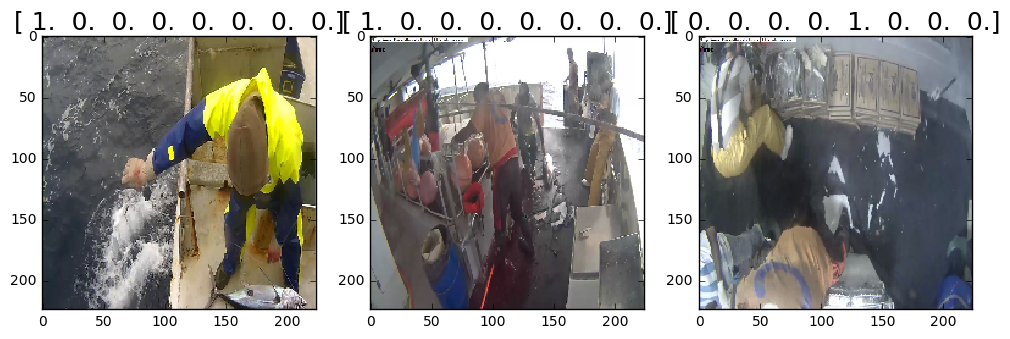

In [13]:
batch_size = 3
batches = get_batches('sample', batch_size=batch_size)
val_batches = get_batches('validation', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [16]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    #print('First 5 classes: {}'.format(classes[:5]))
    #print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

Get the 1000 class descriptions from imagenet in order to know what class is predicted

In [14]:
FILES_PATH = 'http://www.platform.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

16384/35363 [============>.................] - ETA: 0s

In [17]:
pred_batch(imgs)

Shape: (3, 1000)
Predictions prob/class: 
  0.2924/macaw
  0.3175/submarine
  0.0522/balloon


### Train classifier on top
We already have the model, so we first get the predictions for 1000 classes, then train the classifier on top

In [43]:
val_batches = get_batches('/home/ubuntu/data/fisheries/data/validation', shuffle=False, batch_size=32)
batches = get_batches('/home/ubuntu/data/fisheries/data/train', shuffle=False, batch_size=32)

Found 3025 images belonging to 8 classes.


Save pre-processed data as arrays to skip this step in the future

In [27]:
#def get_data(path, target_size=(224,224)):
#    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
#    return np.concatenate([batches.next() for i in range(batches.nb_sample)])
# Funktion aus utils.py -> funktioniert nicht... 

In [33]:
from utils import plots, get_batches, plot_confusion_matrix, get_data

trn_data = get_data('/home/ubuntu/data/fisheries/data/train/')
print(trn_data.shape)
print(type(trn_data))
print(trn_data.shape[0,:,:,:])

Found 3025 images belonging to 8 classes.
(3025, 3, 224, 224)


In [49]:
val_data = get_data('/home/ubuntu/data/fisheries/data/validation')
print(val_data.shape)

Found 752 images belonging to 8 classes.
(752, 3, 224, 224)


This is just for saving the trn_data arrays to skip the previous step. Helpful when using a slow system

In [52]:
import bcolz
def save_array(fname, arr): 
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [ ]:
# save_array(...)

In [30]:
# workaround using np arrays
type(trn_data)
with open("/home/ubuntu/data/fisheries/data/preprocessed_subsample_images.npy", 'wb') as f:
    trn_data.tofile(f)

In [20]:
with open("/home/ubuntu/data/fisheries/data/preprocessed_subsample_images.npy", 'rb') as f:
    trn_data = np.fromfile(f)

From discrete classes [ 7,7,5,6,...] to one-hot encoding 

In [39]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x):
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [45]:
trn_classes = batches.classes
trn_labels = onehot(trn_classes)

val_classes = val_batches.classes
val_labels = onehot(val_classes)

In [46]:
print(trn_classes.shape)
print(trn_classes)
print(trn_labels)

(3025,)
[0 0 0 ..., 7 7 7]
[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


Now make predictions from the pre-trained model (vector with length 1000)

In [47]:
trn_features = model.predict(trn_data, batch_size=batch_size)
print(trn_features.shape)

(3025, 1000)


In [50]:
val_features = model.predict(val_data, batch_size=batch_size)
print(val_features.shape)

(752, 1000)


In [53]:
save_array("/home/ubuntu/data/fisheries/data/train_features_1000.bc", trn_features)
save_array("/home/ubuntu/data/fisheries/data/val_features_1000.bc", val_features)

In [54]:
trn_features = load_array("/home/ubuntu/data/fisheries/data/train_features_1000.bc")
val_features = load_array("/home/ubuntu/data/fisheries/data/val_features_1000.bc")

In [55]:
print(trn_features.shape)
print(val_features.shape)

(3025, 1000)
(752, 1000)


In [56]:
# 1000 inputs, since that's the saved features, and 8 outputs, one for each breed of fish
lm = Sequential([ Dense(8, activation='softmax', input_shape=(1000,)) ])
lm.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
lm.fit(trn_features, trn_labels, validation_split=0.1, nb_epoch=5, batch_size=32)

Train on 2722 samples, validate on 303 samples
Epoch 1/5
2722/2722 [==============================] - 0s - loss: 0.6396 - acc: 0.7759 - val_loss: 1.4595 - val_acc: 0.4719
Epoch 2/5
2722/2722 [==============================] - 0s - loss: 0.6111 - acc: 0.7869 - val_loss: 1.1070 - val_acc: 0.6370
Epoch 3/5
2722/2722 [==============================] - 0s - loss: 0.5873 - acc: 0.8020 - val_loss: 1.5870 - val_acc: 0.3960
Epoch 4/5
2722/2722 [==============================] - 0s - loss: 0.5656 - acc: 0.8071 - val_loss: 1.5243 - val_acc: 0.4257
Epoch 5/5
2722/2722 [==============================] - 0s - loss: 0.5453 - acc: 0.8148 - val_loss: 1.0048 - val_acc: 0.7261


In [59]:
subs_preds = lm.predict(trn_features, batch_size=batch_size)

In [60]:
print(subs_preds[:5])
print(subs_preds.shape)

[[  3.6261e-01   1.0598e-02   3.0786e-03   3.4301e-06   5.4511e-03   5.6620e-01   3.6392e-02
    1.5664e-02]
 [  8.1762e-01   2.7208e-02   9.1031e-05   6.8756e-03   8.4977e-02   1.1125e-02   1.3199e-07
    5.2106e-02]
 [  2.1990e-01   3.8163e-03   1.3008e-06   1.7458e-02   2.6857e-02   7.2614e-01   3.5051e-16
    5.8307e-03]
 [  6.9108e-01   3.1575e-03   1.7813e-04   6.2772e-02   3.7355e-02   1.0750e-01   3.2512e-11
    9.7953e-02]
 [  6.5468e-01   2.7972e-03   1.9893e-04   1.2830e-06   4.4678e-02   3.0098e-02   4.9623e-02
    2.1792e-01]]
(3025, 8)


### Make a Kaggle submission (i.e. predict the testset)

In [47]:
model.add(lm)

In [4]:
print(model.summary())

NameError: name 'model' is not defined

In [63]:
# make predistions on the test set
test_batches = get_batches("/home/ubuntu/data/fisheries/data/test", shuffle=False, batch_size = 24, class_mode=None)
#test_data = get_data("/home/ubuntu/data/fisheries/data/test")
test_preds = model.predict_generator(test_batches, test_batches.nb_sample)

In [64]:
test_preds2 = lm.predict(test_preds, batch_size=batch_size)

In [65]:
print(test_preds2[:5])
print(test_preds2.shape)
print(test_batches.filenames[:5])

[[  9.6505e-01   1.6328e-05   8.9247e-08   4.4621e-04   3.4335e-02   1.0952e-05   1.3991e-04
    2.3497e-06]
 [  1.3208e-01   2.2734e-02   1.0342e-02   1.9042e-04   1.7101e-03   8.3149e-01   8.6403e-05
    1.3621e-03]
 [  3.7226e-01   1.0256e-03   3.5671e-05   6.4722e-08   7.9423e-02   5.6663e-03   2.9165e-02
    5.1243e-01]
 [  5.2294e-02   7.6833e-06   2.4449e-09   8.7942e-01   1.2471e-04   6.8122e-02   6.1780e-10
    3.5308e-05]
 [  6.5220e-01   3.4071e-02   2.4234e-03   3.7801e-04   8.3011e-03   1.1465e-04   3.9295e-06
    3.0250e-01]]
(1000, 8)
['test_stg1/img_05016.jpg', 'test_stg1/img_06186.jpg', 'test_stg1/img_02890.jpg', 'test_stg1/img_02834.jpg', 'test_stg1/img_01888.jpg']


In [68]:
filenames = test_batches.filenames
print(np.array(filenames).shape)
print(filenames[0])

(1000,)
test_stg1/img_05016.jpg


In [72]:
ids = np.array([f[f.find('/')+1:] for f in filenames])
print(ids)

['img_05016.jpg' 'img_06186.jpg' 'img_02890.jpg' 'img_02834.jpg' 'img_01888.jpg' 'img_05615.jpg'
 'img_00724.jpg' 'img_03252.jpg' 'img_01388.jpg' 'img_03677.jpg' 'img_06076.jpg' 'img_03346.jpg'
 'img_05719.jpg' 'img_06521.jpg' 'img_05813.jpg' 'img_04511.jpg' 'img_06021.jpg' 'img_00469.jpg'
 'img_07192.jpg' 'img_02811.jpg' 'img_03355.jpg' 'img_05433.jpg' 'img_07199.jpg' 'img_00417.jpg'
 'img_05393.jpg' 'img_05817.jpg' 'img_05950.jpg' 'img_01627.jpg' 'img_07678.jpg' 'img_05613.jpg'
 'img_00708.jpg' 'img_06010.jpg' 'img_05328.jpg' 'img_07561.jpg' 'img_07905.jpg' 'img_04921.jpg'
 'img_05672.jpg' 'img_01561.jpg' 'img_00999.jpg' 'img_02699.jpg' 'img_02949.jpg' 'img_00484.jpg'
 'img_07270.jpg' 'img_04204.jpg' 'img_05119.jpg' 'img_06207.jpg' 'img_06522.jpg' 'img_06637.jpg'
 'img_07409.jpg' 'img_05766.jpg' 'img_00493.jpg' 'img_04145.jpg' 'img_00575.jpg' 'img_02916.jpg'
 'img_07045.jpg' 'img_02666.jpg' 'img_02406.jpg' 'img_06424.jpg' 'img_00232.jpg' 'img_02702.jpg'
 'img_07187.jpg' 'img_05520.jp

In [85]:
subm = np.column_stack([ids, test_preds])

In [86]:
print(subm)

[['img_05016.jpg' '1.64499469975e-05' '0.000112272107799' ..., '1.63128197528e-06'
  '2.00240792765e-05' '4.07691404689e-05']
 ['img_06186.jpg' '0.00126420310698' '0.00228715781122' ..., '1.99107876142e-06' '2.59877488133e-05'
  '0.000330337003106']
 ['img_02890.jpg' '6.55681469652e-06' '2.6013552997e-05' ..., '5.63988358238e-08'
  '3.51877270077e-06' '1.94783933694e-06']
 ..., 
 ['img_06921.jpg' '1.94302047021e-05' '0.000474124914035' ..., '2.90931143354e-06'
  '3.48557296093e-05' '4.48376231361e-05']
 ['img_04757.jpg' '6.75228193359e-07' '5.70144220546e-06' ..., '8.02911586106e-07'
  '1.57294762175e-05' '2.08951041714e-05']
 ['img_03563.jpg' '4.62766092824e-06' '7.20267125871e-05' ..., '6.11721247878e-07'
  '0.000232470934861' '5.28764667251e-06']]


In [91]:
%cd ~/data/fisheries/data/
np.savetxt('test_submission.csv', subm, header="image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT")

/home/ubuntu/data/fisheries/data


TypeError: Mismatch between array dtype ('|S32') and format specifier ('%.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e %.18e')